In [52]:
import json
from typing import TypedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from constants import DATA_DIR
from scipy import stats
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
from xgboost import XGBRegressor

sns.set_theme()

In [10]:
FEATURES_DIR = DATA_DIR / "features"

SELECTED_DATASET = 45
MAX_PERIOD = 45

In [3]:
feature_files = [file for file in FEATURES_DIR.iterdir() if file.suffix == ".json"]
len(feature_files)

192

In [4]:
class AsteroidData(TypedDict):
    is_failed: bool
    reason: str | None
    period: float
    processing_time: float
    features: np.ndarray

In [44]:
feature_file = feature_files[SELECTED_DATASET - 1]

with open(feature_file, "r") as f:
    loaded_data = json.load(f)

    config, asteroids_data = loaded_data["config"], loaded_data["asteroids"]

    filtered_data = {
        name: AsteroidData(**data)
        for name, data in asteroids_data.items()
        if not data["is_failed"] and data["period"] <= MAX_PERIOD
    }

    clipped_data = []
    periods = []
    for asteroid_name, data in filtered_data.items():
        arr = np.array(data["features"])

        idx = np.argsort(arr[:, :, 1].flatten())[::-1][:50]
        seq_idx, row_idx = np.unravel_index(idx, arr[:, :, 1].shape)

        clipped_data.append(arr[seq_idx, row_idx])
        periods.append(data["period"])

    clipped_data = np.array(clipped_data)
    periods = np.array(periods)

In [45]:
clipped_data.shape, periods.shape

((523, 50, 2), (523,))

In [46]:
X_train, X_val_test, y_train, y_val_test = train_test_split(
    clipped_data,
    periods,
    test_size=0.2,
    random_state=88688,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.33, random_state=88688
)

no_samples, seq_len, no_features = X_train.shape
X_train = X_train.reshape(-1, seq_len * no_features)
X_val = X_val.reshape(-1, seq_len * no_features)
X_test = X_test.reshape(-1, seq_len * no_features)

X_train.shape, X_val.shape, X_test.shape

((418, 100), (70, 100), (35, 100))

In [47]:
model = XGBRegressor(
    n_estimators=1000,
    max_depth=10,
    learning_rate=0.01,
    n_jobs=-1,
    random_state=88688,
)
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=88688, ...)

In [48]:
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

[0]	validation_0-rmse:7.54279
[1]	validation_0-rmse:7.49930
[2]	validation_0-rmse:7.45644
[3]	validation_0-rmse:7.41457
[4]	validation_0-rmse:7.37298
[5]	validation_0-rmse:7.33172
[6]	validation_0-rmse:7.29194
[7]	validation_0-rmse:7.25212
[8]	validation_0-rmse:7.21514
[9]	validation_0-rmse:7.17723
[10]	validation_0-rmse:7.14121
[11]	validation_0-rmse:7.10413
[12]	validation_0-rmse:7.06950
[13]	validation_0-rmse:7.03261
[14]	validation_0-rmse:6.99866
[15]	validation_0-rmse:6.96412
[16]	validation_0-rmse:6.93077
[17]	validation_0-rmse:6.89654
[18]	validation_0-rmse:6.86465
[19]	validation_0-rmse:6.83182
[20]	validation_0-rmse:6.80164
[21]	validation_0-rmse:6.76921
[22]	validation_0-rmse:6.74112
[23]	validation_0-rmse:6.71023
[24]	validation_0-rmse:6.68119
[25]	validation_0-rmse:6.65255
[26]	validation_0-rmse:6.62464
[27]	validation_0-rmse:6.59602
[28]	validation_0-rmse:6.57024
[29]	validation_0-rmse:6.54200
[30]	validation_0-rmse:6.51548
[31]	validation_0-rmse:6.48884
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=88688, ...)

In [49]:
score = model.score(X_test, y_test)
print(f"R^2 score: {score:.4f}")

R^2 score: 0.6104


True: 19.88, Predicted: 17.79
True:  9.30, Predicted: 12.68
True: 14.36, Predicted: 29.64
True:  7.32, Predicted: 14.39
True:  4.78, Predicted:  4.07
True:  4.00, Predicted:  6.27
True: 16.14, Predicted: 15.59
True:  9.38, Predicted: 10.91
True:  4.32, Predicted:  4.82
True: 12.80, Predicted: 13.88
True: 27.24, Predicted: 30.96
True: 16.81, Predicted: 14.17
True:  3.08, Predicted:  4.32
True:  4.28, Predicted:  4.92
True:  7.16, Predicted:  8.30
True: 12.27, Predicted: 11.56
True:  4.63, Predicted:  4.17
True:  8.70, Predicted:  8.93
True:  4.44, Predicted:  5.35
True: 16.80, Predicted: 20.21
True: 15.71, Predicted: 15.05
True:  5.89, Predicted:  8.29
True:  6.57, Predicted:  7.54
True:  8.76, Predicted:  7.67
True: 24.48, Predicted: 19.91
True: 21.00, Predicted: 24.88
True:  9.16, Predicted:  9.33
True:  8.87, Predicted:  7.15
True:  8.68, Predicted:  7.43
True:  5.92, Predicted:  6.40
True: 13.83, Predicted: 17.81
True:  2.79, Predicted:  3.14
True:  6.34, Predicted:  5.91
True:  4.9

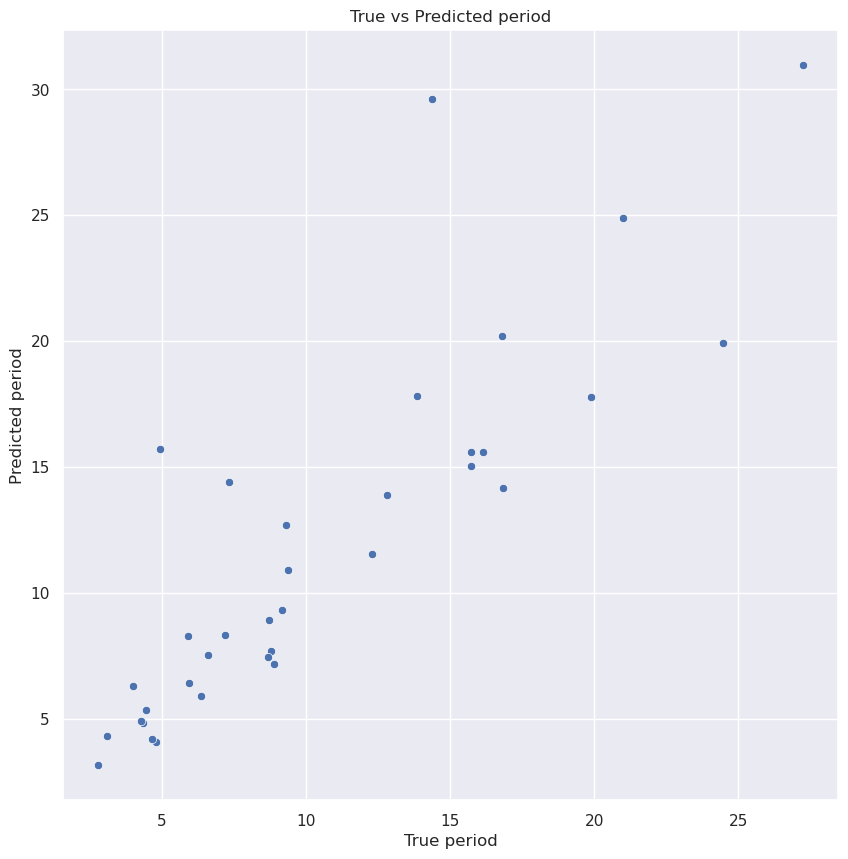

In [50]:
predictions = model.predict(X_test)

for (true, pred) in zip(y_test.flatten(), predictions):
    print(f"True: {true:5.2f}, Predicted: {pred:5.2f}")

plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test.flatten(), y=predictions)
plt.xlabel("True period")
plt.ylabel("Predicted period")
plt.title("True vs Predicted period")
plt.show()

DecisionTreeRegressor R^2 score: -0.2222


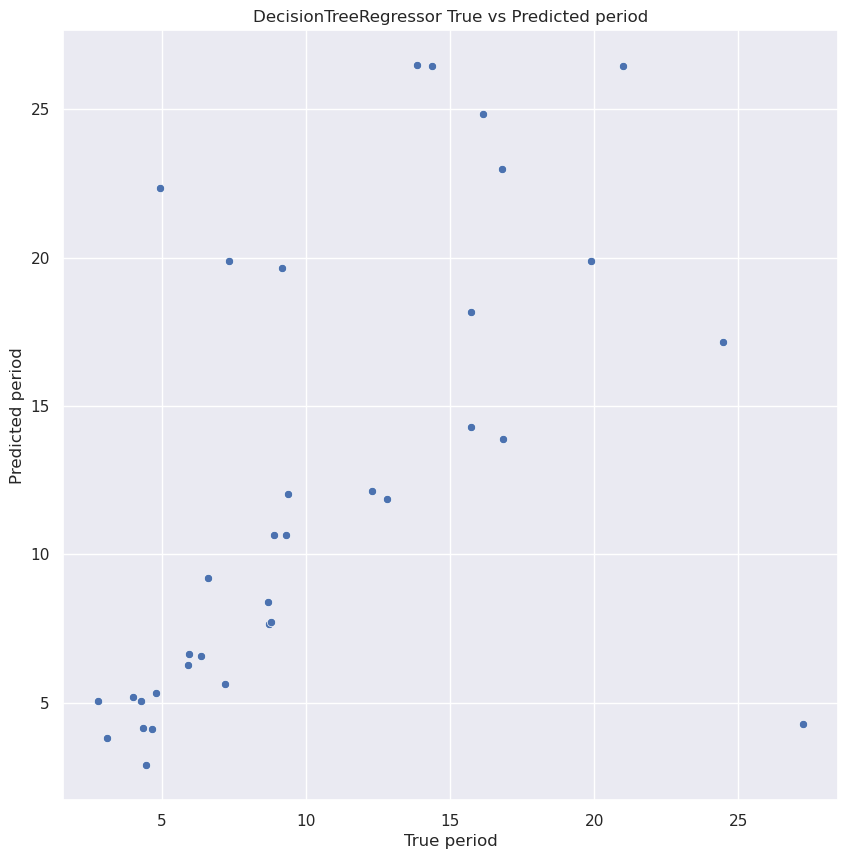

True: 19.88, Predicted: 19.90
True:  9.30, Predicted: 10.67
True: 14.36, Predicted: 26.46
True:  7.32, Predicted: 19.90
True:  4.78, Predicted:  5.33
True:  4.00, Predicted:  5.18
True: 16.14, Predicted: 24.85
True:  9.38, Predicted: 12.03
True:  4.32, Predicted:  4.15
True: 12.80, Predicted: 11.87
True: 27.24, Predicted:  4.27
True: 16.81, Predicted: 13.88
True:  3.08, Predicted:  3.82
True:  4.28, Predicted:  5.05
True:  7.16, Predicted:  5.62
True: 12.27, Predicted: 12.15
True:  4.63, Predicted:  4.12
True:  8.70, Predicted:  7.67
True:  4.44, Predicted:  2.89
True: 16.80, Predicted: 22.99
True: 15.71, Predicted: 18.17
True:  5.89, Predicted:  6.26
True:  6.57, Predicted:  9.19
True:  8.76, Predicted:  7.72
True: 24.48, Predicted: 17.15
True: 21.00, Predicted: 26.46
True:  9.16, Predicted: 19.66
True:  8.87, Predicted: 10.67
True:  8.68, Predicted:  8.39
True:  5.92, Predicted:  6.65
True: 13.83, Predicted: 26.49
True:  2.79, Predicted:  5.05
True:  6.34, Predicted:  6.59
True:  4.9

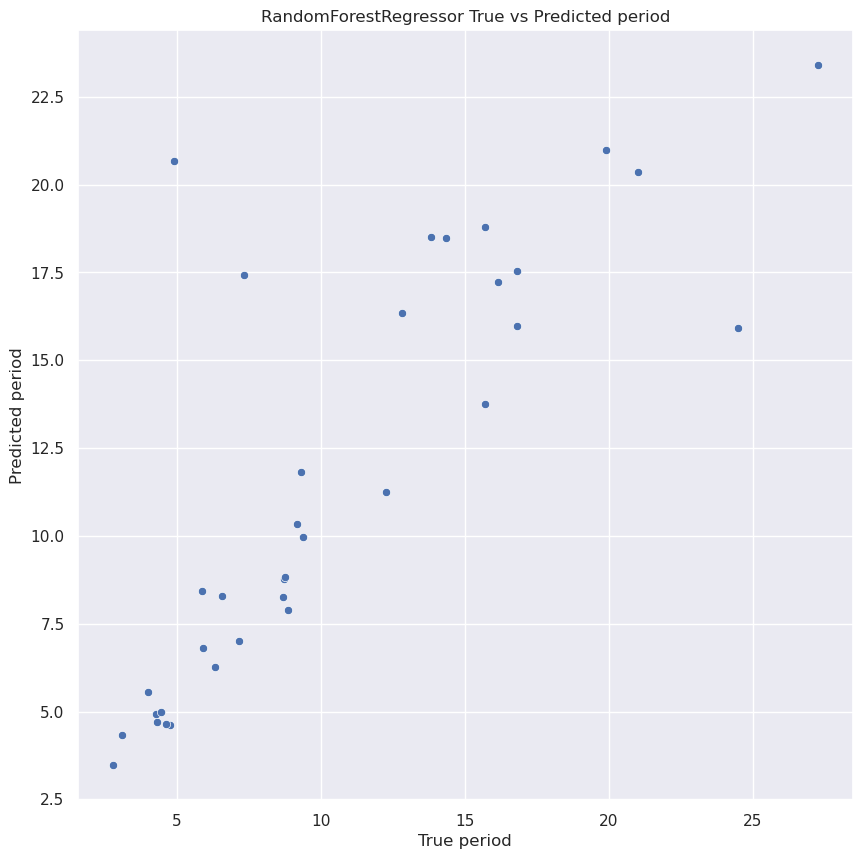

True: 19.88, Predicted: 20.99
True:  9.30, Predicted: 11.83
True: 14.36, Predicted: 18.47
True:  7.32, Predicted: 17.42
True:  4.78, Predicted:  4.62
True:  4.00, Predicted:  5.55
True: 16.14, Predicted: 17.24
True:  9.38, Predicted:  9.96
True:  4.32, Predicted:  4.69
True: 12.80, Predicted: 16.36
True: 27.24, Predicted: 23.40
True: 16.81, Predicted: 15.99
True:  3.08, Predicted:  4.33
True:  4.28, Predicted:  4.92
True:  7.16, Predicted:  6.99
True: 12.27, Predicted: 11.24
True:  4.63, Predicted:  4.65
True:  8.70, Predicted:  8.76
True:  4.44, Predicted:  4.98
True: 16.80, Predicted: 17.55
True: 15.71, Predicted: 18.80
True:  5.89, Predicted:  8.42
True:  6.57, Predicted:  8.30
True:  8.76, Predicted:  8.83
True: 24.48, Predicted: 15.91
True: 21.00, Predicted: 20.37
True:  9.16, Predicted: 10.35
True:  8.87, Predicted:  7.89
True:  8.68, Predicted:  8.27
True:  5.92, Predicted:  6.81
True: 13.83, Predicted: 18.51
True:  2.79, Predicted:  3.47
True:  6.34, Predicted:  6.28
True:  4.9

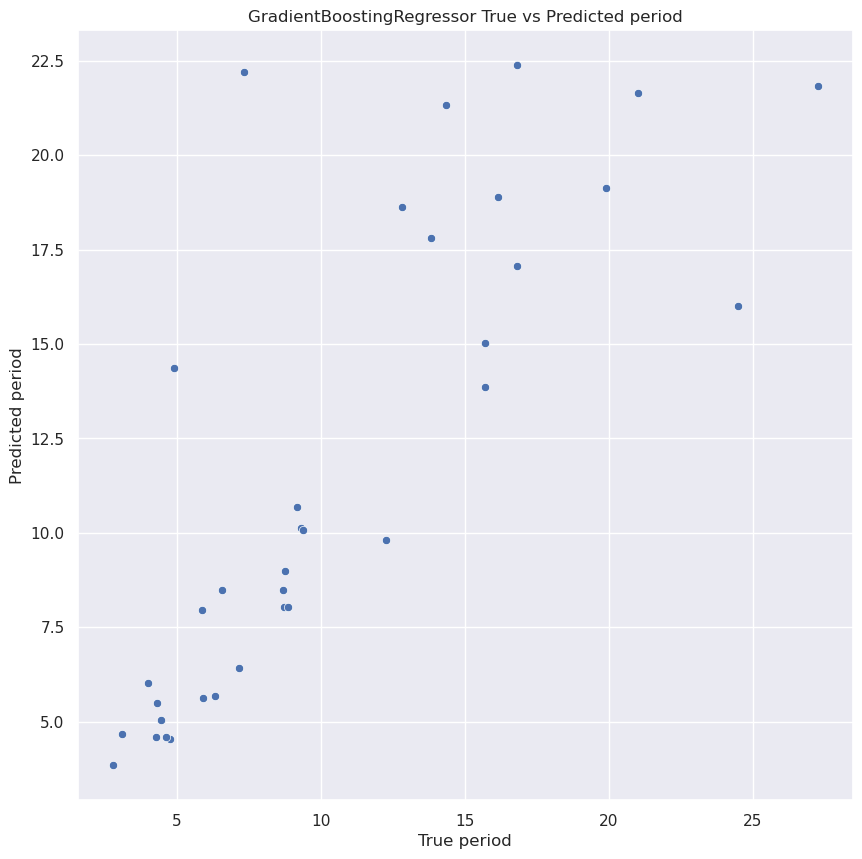

True: 19.88, Predicted: 19.15
True:  9.30, Predicted: 10.13
True: 14.36, Predicted: 21.35
True:  7.32, Predicted: 22.21
True:  4.78, Predicted:  4.53
True:  4.00, Predicted:  6.01
True: 16.14, Predicted: 18.90
True:  9.38, Predicted: 10.06
True:  4.32, Predicted:  5.50
True: 12.80, Predicted: 18.62
True: 27.24, Predicted: 21.84
True: 16.81, Predicted: 17.06
True:  3.08, Predicted:  4.66
True:  4.28, Predicted:  4.59
True:  7.16, Predicted:  6.43
True: 12.27, Predicted:  9.82
True:  4.63, Predicted:  4.58
True:  8.70, Predicted:  8.04
True:  4.44, Predicted:  5.05
True: 16.80, Predicted: 22.39
True: 15.71, Predicted: 15.03
True:  5.89, Predicted:  7.95
True:  6.57, Predicted:  8.48
True:  8.76, Predicted:  8.99
True: 24.48, Predicted: 16.02
True: 21.00, Predicted: 21.64
True:  9.16, Predicted: 10.68
True:  8.87, Predicted:  8.03
True:  8.68, Predicted:  8.50
True:  5.92, Predicted:  5.63
True: 13.83, Predicted: 17.82
True:  2.79, Predicted:  3.84
True:  6.34, Predicted:  5.69
True:  4.9

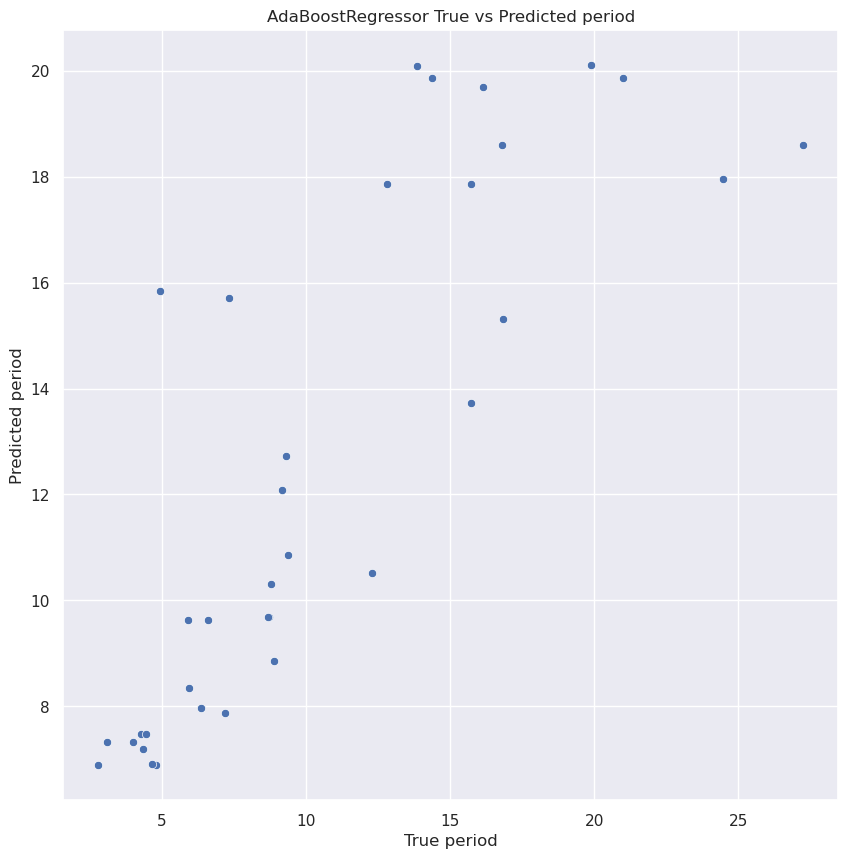

True: 19.88, Predicted: 20.10
True:  9.30, Predicted: 12.72
True: 14.36, Predicted: 19.86
True:  7.32, Predicted: 15.71
True:  4.78, Predicted:  6.89
True:  4.00, Predicted:  7.33
True: 16.14, Predicted: 19.70
True:  9.38, Predicted: 10.85
True:  4.32, Predicted:  7.20
True: 12.80, Predicted: 17.86
True: 27.24, Predicted: 18.60
True: 16.81, Predicted: 15.31
True:  3.08, Predicted:  7.33
True:  4.28, Predicted:  7.48
True:  7.16, Predicted:  7.89
True: 12.27, Predicted: 10.52
True:  4.63, Predicted:  6.91
True:  8.70, Predicted:  9.69
True:  4.44, Predicted:  7.48
True: 16.80, Predicted: 18.59
True: 15.71, Predicted: 17.86
True:  5.89, Predicted:  9.63
True:  6.57, Predicted:  9.63
True:  8.76, Predicted: 10.30
True: 24.48, Predicted: 17.96
True: 21.00, Predicted: 19.86
True:  9.16, Predicted: 12.08
True:  8.87, Predicted:  8.87
True:  8.68, Predicted:  9.69
True:  5.92, Predicted:  8.35
True: 13.83, Predicted: 20.09
True:  2.79, Predicted:  6.90
True:  6.34, Predicted:  7.98
True:  4.9

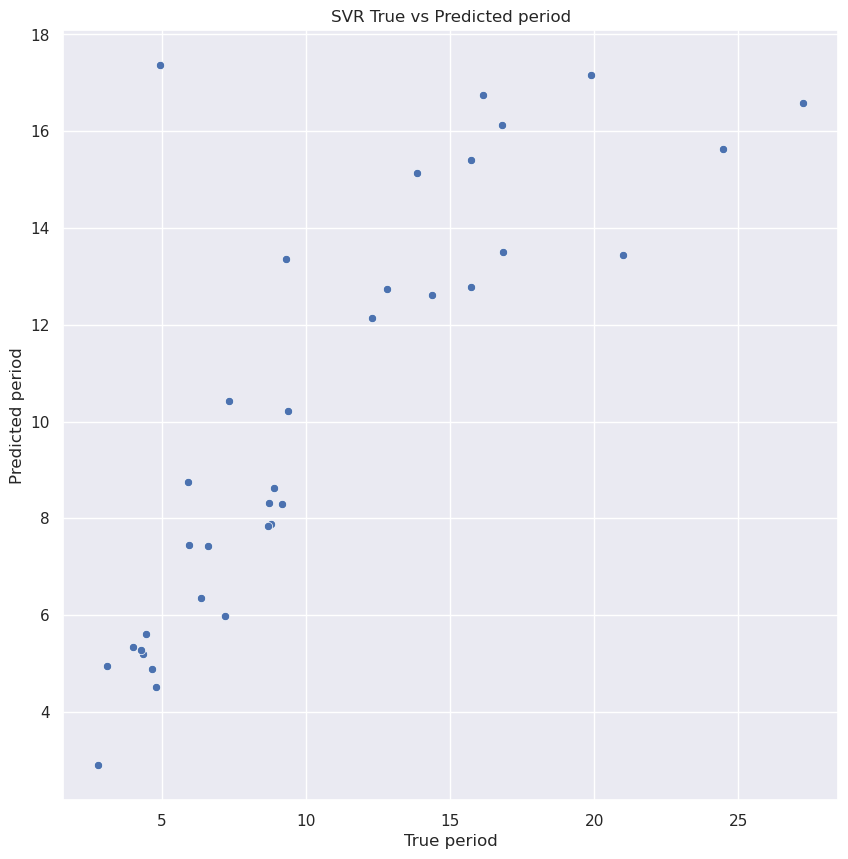

True: 19.88, Predicted: 17.17
True:  9.30, Predicted: 13.36
True: 14.36, Predicted: 12.61
True:  7.32, Predicted: 10.43
True:  4.78, Predicted:  4.52
True:  4.00, Predicted:  5.34
True: 16.14, Predicted: 16.76
True:  9.38, Predicted: 10.22
True:  4.32, Predicted:  5.19
True: 12.80, Predicted: 12.74
True: 27.24, Predicted: 16.58
True: 16.81, Predicted: 13.50
True:  3.08, Predicted:  4.94
True:  4.28, Predicted:  5.28
True:  7.16, Predicted:  5.98
True: 12.27, Predicted: 12.13
True:  4.63, Predicted:  4.88
True:  8.70, Predicted:  8.31
True:  4.44, Predicted:  5.61
True: 16.80, Predicted: 16.13
True: 15.71, Predicted: 15.41
True:  5.89, Predicted:  8.76
True:  6.57, Predicted:  7.43
True:  8.76, Predicted:  7.88
True: 24.48, Predicted: 15.62
True: 21.00, Predicted: 13.45
True:  9.16, Predicted:  8.30
True:  8.87, Predicted:  8.63
True:  8.68, Predicted:  7.83
True:  5.92, Predicted:  7.45
True: 13.83, Predicted: 15.14
True:  2.79, Predicted:  2.90
True:  6.34, Predicted:  6.35
True:  4.9

In [53]:
test_models = [
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    SVR(),
]

for model in test_models:
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)

    predictions = model.predict(X_test)

    plt.figure(figsize=(10, 10))
    sns.scatterplot(x=y_test.flatten(), y=predictions)
    plt.xlabel("True period")
    plt.ylabel("Predicted period")
    plt.title(f"{model.__class__.__name__} True vs Predicted period")
    plt.show()

    for (true, pred) in zip(y_test.flatten(), predictions):
        print(f"True: {true:5.2f}, Predicted: {pred:5.2f}")

    print(f"{model.__class__.__name__} R^2 score: {score:.4f}")